In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

import src.visualization.visualize as VizManager
import src.data.NHLDataManager as DataManager
import src.features.build_features as FeaturesManager

In [77]:
seasons_year = [2015, 2016, 2017, 2018]
features_data_df = FeaturesManager.build_features(seasons_year, with_player_stats=True)
features_data_df['Game ID'].unique()

2015
2016
2017
2018


array(['2015020001', '2015020002', '2015020003', ..., '2018021269',
       '2018021270', '2018021271'], dtype=object)

In [135]:
# features_data_df.query("`Game ID` == '2018020192' & Type == 'GOAL'")[['Game ID', 'Team', 'X', 'Y', 'st_X', 'st_Y', 'Period', 'Period seconds', 'Rebound']]
print(features_data_df.query("(st_X < -40) and (`Is Empty` == 1)").shape)
print(features_data_df.shape)

(9959, 34)
(305860, 34)


In [120]:
data_manager = DataManager.NHLDataManager()
df = data_manager.get_goals_and_shots_df_standardised(2018, 'Regular', 192)
df.query("Type == 'GOAL'")[['Team', 'X', 'Y', 'st_X', 'st_Y']]

[{'periodType': 'REGULAR', 'startTime': '2018-11-03T01:16:02Z', 'endTime': '2018-11-03T01:54:15Z', 'num': 1, 'ordinalNum': '1st', 'home': {'goals': 2, 'shotsOnGoal': 14, 'rinkSide': 'right'}, 'away': {'goals': 1, 'shotsOnGoal': 10, 'rinkSide': 'left'}}, {'periodType': 'REGULAR', 'startTime': '2018-11-03T02:14:08Z', 'endTime': '2018-11-03T02:52:07Z', 'num': 2, 'ordinalNum': '2nd', 'home': {'goals': 0, 'shotsOnGoal': 3, 'rinkSide': 'left'}, 'away': {'goals': 2, 'shotsOnGoal': 12, 'rinkSide': 'right'}}, {'periodType': 'REGULAR', 'startTime': '2018-11-03T03:10:49Z', 'endTime': '2018-11-03T03:50:41Z', 'num': 3, 'ordinalNum': '3rd', 'home': {'goals': 0, 'shotsOnGoal': 17, 'rinkSide': 'right'}, 'away': {'goals': 1, 'shotsOnGoal': 4, 'rinkSide': 'left'}}]
[False, True, False]
[True, False, True]
WPG
FLA


,Team,X,Y,st_X,st_Y
0,Winnipeg Jets (WPG),81.0,5.0,-81.0,-5.0
1,Florida Panthers (FLA),-76.0,2.0,-76.0,2.0
2,Winnipeg Jets (WPG),69.0,-24.0,-69.0,24.0
3,Florida Panthers (FLA),58.0,-21.0,-58.0,21.0
4,Florida Panthers (FLA),41.0,-6.0,-41.0,6.0
5,Florida Panthers (FLA),-58.0,2.0,-58.0,2.0


In [16]:
names_all = list(features_data_df.columns) 


names = ['Period', 'Shot Type', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Is Empty', 'Rebound', 'Change in Shot Angle', 
         'Speed From Previous Event', 'Game seconds', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance',
         'Is Goal']

feature_names, target_name = names[0:-2], names[-1]
feature_names = np.array(feature_names)

df_filter = features_data_df[names]

print(feature_names)

# Be careful with dropna. For example, if we choose the 'Strenght' feature, if will remove all the shots
df_filter = df_filter.dropna()

df_filter[df_filter.isna().any(axis=1)]

['Period' 'Shot Type' 'st_X' 'st_Y' 'Shot distance' 'Shot angle'
 'Is Empty' 'Rebound' 'Change in Shot Angle' 'Speed From Previous Event'
 'Game seconds' 'Last event st_X' 'Last event st_Y'
 'Last event elapsed time']


,Period,Shot Type,st_X,st_Y,Shot distance,Shot angle,Is Empty,Rebound,Change in Shot Angle,Speed From Previous Event,Game seconds,Last event st_X,Last event st_Y,Last event elapsed time,Last event distance,Is Goal


In [17]:
df_filter.describe()

,st_X,st_Y,Shot distance,Shot angle,Change in Shot Angle,Speed From Previous Event,Last event st_X,Last event st_Y,Last event distance
count,225926.000000,225926.000000,225926.000000,225926.000000,225926.000000,225926.000000,225926.000000,225926.000000,225926.000000
mean,58.276307,-0.076096,36.256872,-0.802287,7.373164,7.995780,23.666856,-0.042509,61.872265
std,24.909188,19.082997,24.779368,36.758944,19.747586,10.105915,60.209921,23.060182,46.028647
min,-99.000000,-42.000000,1.000000,-161.565051,0.000000,0.000000,-99.000000,-42.000000,0.000000
25%,45.000000,-14.000000,17.262677,-28.739795,0.000000,2.121175,-34.000000,-22.000000,26.248809
50%,63.000000,0.000000,33.301652,0.000000,0.000000,4.708871,50.000000,-0.000000,46.840154
75%,76.000000,14.000000,49.517674,27.474432,0.000000,10.038599,69.000000,22.000000,92.195445
max,99.000000,42.000000,189.654950,180.000000,209.528672,186.625293,99.000000,42.000000,200.000000


In [18]:
dummy_shot_type = pd.get_dummies(df_filter['Shot Type'], prefix='Shot Type')
df_filter = df_filter.merge(dummy_shot_type, left_index=True, right_index=True)
df_filter = df_filter.drop(columns=['Shot Type'])

# Update features_name
feature_names = list(df_filter.columns)
feature_names = [f for f in feature_names if f != 'Is Goal']
feature_names = np.array(feature_names)
print(feature_names)


df_filter.sample(10)
print

['Period' 'st_X' 'st_Y' 'Shot distance' 'Shot angle' 'Is Empty' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event' 'Game seconds'
 'Last event st_X' 'Last event st_Y' 'Last event elapsed time'
 'Last event distance' 'Shot Type_Backhand' 'Shot Type_Deflected'
 'Shot Type_Slap Shot' 'Shot Type_Snap Shot' 'Shot Type_Tip-In'
 'Shot Type_Wrap-around' 'Shot Type_Wrist Shot']


<function print>

In [19]:
df_train, df_valid = train_test_split(df_filter, test_size=0.2, random_state=42)

In [20]:
X_train = df_train[feature_names].to_numpy()
y_train = df_train[target_name].to_numpy()

X_valid = df_valid[feature_names].to_numpy()
y_valid = df_valid[target_name].to_numpy()

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)




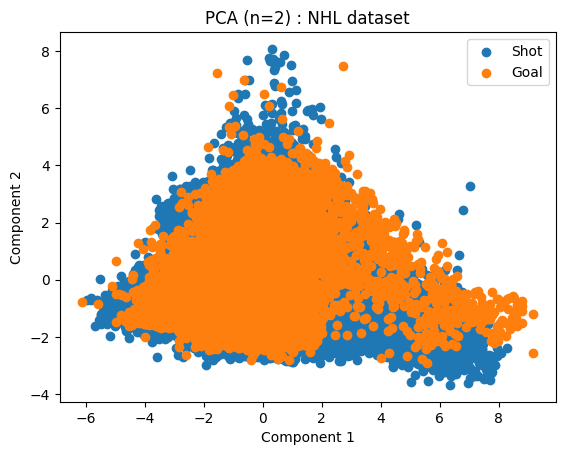

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_r = pca.fit(X_train_scaled).transform(X_train_scaled)

target_names = ['Shot', 'Goal']

for i, target_name in enumerate(target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], label=target_name)

plt.legend(loc='best', scatterpoints=1)

plt.title('PCA (n=2) : NHL dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.plot();

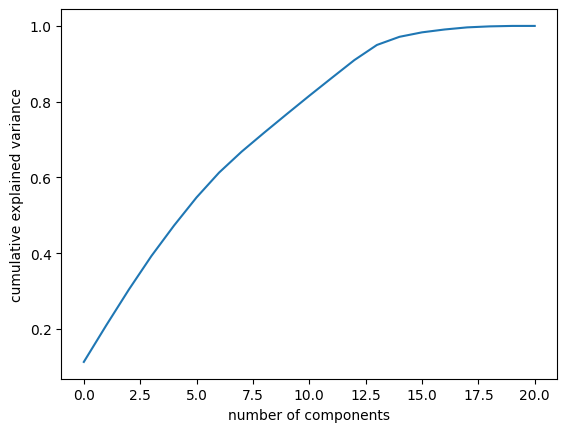

In [26]:
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [49]:
X_train.mean()

96.82208131137436

In [50]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Lasso SVC
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_train_scaled, y_train)

# Select features based on Lasso
model = SelectFromModel(lsvc)

model.fit(X_train_scaled,y_train)

print('Selected Support : ', model.get_support())

print('Selected Features: ', feature_names[model.get_support()])
print('Rejected Features: ', feature_names[~model.get_support()])

# features = model.transform(X_train)
# print('Selected Features shape: ', features.shape)

Selected Support :  [ True  True False  True False  True  True  True  True False False False
  True  True  True  True  True False  True  True  True]
Selected Features:  ['Period' 'st_X' 'Shot distance' 'Is Empty' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event'
 'Last event elapsed time' 'Last event distance' 'Shot Type_Backhand'
 'Shot Type_Deflected' 'Shot Type_Slap Shot' 'Shot Type_Tip-In'
 'Shot Type_Wrap-around' 'Shot Type_Wrist Shot']
Rejected Features:  ['st_Y' 'Shot angle' 'Game seconds' 'Last event st_X' 'Last event st_Y'
 'Shot Type_Snap Shot']


In [51]:
# p (1-p) - Only for Boolean features
# Remove all features that are either one or zero (on or off) in more than (100*p)% of the samples
p = 0.9
selector = VarianceThreshold(threshold=(p * (1 - p)))
features = selector.fit_transform(X_train)

print('Selected Features: ', feature_names[selector.get_support()])
print('Rejected Features: ', feature_names[~selector.get_support()])

Selected Features:  ['Period' 'st_X' 'st_Y' 'Shot distance' 'Shot angle' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event' 'Game seconds'
 'Last event st_X' 'Last event st_Y' 'Last event elapsed time'
 'Last event distance' 'Shot Type_Slap Shot' 'Shot Type_Snap Shot'
 'Shot Type_Wrist Shot']
Rejected Features:  ['Is Empty' 'Shot Type_Backhand' 'Shot Type_Deflected' 'Shot Type_Tip-In'
 'Shot Type_Wrap-around']


In [52]:
# Feature Selection with chi-square

# Features should be non negative. 
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_minmax = min_max_scaler.transform(X_train)
X_valid_minmax = min_max_scaler.transform(X_valid)

# Selection
num_features = 12
selector = SelectKBest(score_func=chi2, k=num_features)
fit = selector.fit(X_train_minmax, y_train)

features = fit.transform(X_train_minmax)

scores = fit.scores_.argsort()[::-1]
print('Selected Features: ', feature_names[scores][:num_features])
print('Rejected Features: ', feature_names[scores][num_features:])

Selected Features:  ['Is Empty' 'Shot Type_Tip-In' 'Shot distance' 'Shot Type_Slap Shot'
 'Shot Type_Deflected' 'Rebound' 'Shot Type_Backhand' 'st_X' 'Period'
 'Game seconds' 'Speed From Previous Event' 'Change in Shot Angle']
Rejected Features:  ['Shot Type_Wrist Shot' 'Last event elapsed time' 'Last event distance'
 'Last event st_X' 'Shot Type_Wrap-around' 'Shot Type_Snap Shot' 'st_Y'
 'Shot angle' 'Last event st_Y']


In [53]:
from sklearn.ensemble import RandomForestClassifier

clf_forest =  RandomForestClassifier(random_state=0).fit(X_train_minmax, y_train)

classifiers = [(clf_forest, 'Random Forest', X_valid_minmax, y_valid)]

# VizManager.plot_all_figures(classifiers, add_random=True)

In [54]:
import time

start_time = time.time()
importances = clf_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

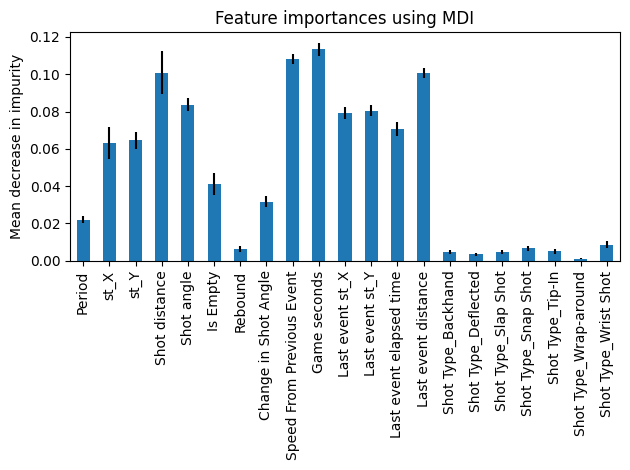

In [55]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") # Mean Decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [56]:
# from sklearn.inspection import permutation_importance

# start_time = time.time()
# result = permutation_importance(
#     clf_forest, X_valid_minmax, y_valid, n_repeats=5, random_state=42, n_jobs=2
# )
# elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# forest_importances = pd.Series(result.importances_mean, index=feature_names)

: 

: 

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf_forest, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()